In [1]:
!pip install pyfaidx

In [2]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.6 MB/s eta 0:00:0000:0100:01


In [3]:
# install torchsummary using pip
!pip install pytorch-lightning


In [4]:
!pip install torchview

In [5]:
import os  # OS interaction
from typing import Tuple  # Type hinting
import numpy as np  # Numerical arrays
import pandas as pd  # Data manipulation
import networkx as nx  # Graph creation and analysis
from collections import defaultdict  # Dicts with default values
import matplotlib.pyplot as plt  # Plotting

from sklearn.preprocessing import LabelEncoder  # Label encoding
from sklearn.metrics import precision_recall_fscore_support  # Performance metrics

from pyfaidx import Fasta  # FASTA file handling
from functools import lru_cache  # Function caching

import torch  # Core deep learning library
import torch.nn as nn  # Neural network layers
import torch.nn.functional as F  # NN functional methods
from torch.utils.data import Dataset  # Custom datasets

from torch_geometric.data import Data, Batch  # Graph data handling
from torch_geometric.nn import GCNConv, global_mean_pool  # GCN layers and pooling
from torch_geometric.utils import from_networkx  # Convert NetworkX to PyTorch Geometric

import pytorch_lightning as pl  # High-level PyTorch framework
# from pytorch_lightning.callbacks import EarlyStopping  # Stop training on no improvement

#from torchsummary import summary
from torchview import draw_graph


In [6]:
### Specify File Path in Here ###

genome_path = "/kaggle/input/mutation/hg38.fa"
mut_filepath = "/kaggle/input/mutation/Mutation_and_healthy_data.csv"


In [7]:
# Read the mutation file
df = pd.read_csv(mut_filepath, low_memory=False)
df


,gene,chr,pos,ref,alt,variation_id,variant_type,clinical_significance
0,APOA2,1,161223893,G,"A,C,T",SNP:5082,snv,harmful
1,CYP21A2;TNXB,6,32041006,C,T,SNP:6445,snv,harmful
2,CYP21A2,6,32040110,G,"A,C,T",SNP:6471,snv,harmful
3,CYP21A2,6,32039426,T,A,SNP:6475,snv,harmful
4,NPC2,14,74484579,A,G,SNP:11694,snv,harmful
...,...,...,...,...,...,...,...,...
1257092,CDH1,16,68811730,G,"A,C",SNP:778959722,snv,non-harmful
1257093,NF1,17,31330479,T,C,SNP:779114598,snv,non-harmful
1257094,SERAC1,6,158114989,A,"-,AA",SNP:780420200,delins,non-harmful
1257095,PALB2,16,23630072,T,C,SNP:781440401,snv,non-harmful


In [8]:
df['chr'].value_counts()


chr
2                 112739
1                 106550
17                 76417
11                 69491
3                  66867
5                  65442
6                  61930
7                  59933
16                 58931
12                 58473
X                  57843
19                 57184
9                  56263
10                 50265
15                 47575
4                  42815
8                  41237
14                 38066
13                 30411
22                 27562
20                 26701
18                 25227
21                 15500
MT                  2869
Y                    799
NW_015148969.2         3
NW_009646203.1         2
NW_009646206.1         2
Name: count, dtype: int64

In [9]:
df[df['ref'].isnull()]


,gene,chr,pos,ref,alt,variation_id,variant_type,clinical_significance
799974,RPL7A;SURF1,9,133351734,NaN,NaN,SNP:879551540,del,non-harmful
1092928,RPL7A;SURF1,9,133351734,NaN,NaN,SNP:879551540,del,non-harmful


In [10]:
out_chroms = ['NW_015148969.2', 'NW_009646203.1', 'NW_009646206.1']
df = df[~df['chr'].isin(out_chroms)]
df = df.drop('variation_id', axis=1).dropna()
df


,gene,chr,pos,ref,alt,variant_type,clinical_significance
0,APOA2,1,161223893,G,"A,C,T",snv,harmful
1,CYP21A2;TNXB,6,32041006,C,T,snv,harmful
2,CYP21A2,6,32040110,G,"A,C,T",snv,harmful
3,CYP21A2,6,32039426,T,A,snv,harmful
4,NPC2,14,74484579,A,G,snv,harmful
...,...,...,...,...,...,...,...
1257092,CDH1,16,68811730,G,"A,C",snv,non-harmful
1257093,NF1,17,31330479,T,C,snv,non-harmful
1257094,SERAC1,6,158114989,A,"-,AA",delins,non-harmful
1257095,PALB2,16,23630072,T,C,snv,non-harmful


In [11]:
df.isnull().sum()


gene                     0
chr                      0
pos                      0
ref                      0
alt                      0
variant_type             0
clinical_significance    0
dtype: int64

In [12]:
df[df['alt'].apply(lambda var: len(var.split(",")) == 5)]


,gene,chr,pos,ref,alt,variant_type,clinical_significance
16148,SPINK5,5,148120312,AAA,"-,A,AA,AAAA,AAAAAAA",delins,harmful
60445,SMPD1;LOC124902624,11,6391633,C,"-,CC,CCAACCCCCC,CCC,CCCGCCCCCCCAACCCCCC",delins,harmful
96526,SPINK5,5,148120312,AAA,"-,A,AA,AAAA,AAAAAAA",delins,harmful
96527,SPINK5,5,148120312,AAA,"-,A,AA,AAAA,AAAAAAA",delins,harmful
96528,SPINK5,5,148120312,AAA,"-,A,AA,AAAA,AAAAAAA",delins,harmful
...,...,...,...,...,...,...,...
1255766,COL4A1,13,110181405,AAAA,"-,AA,AAA,AAAAA,AAAAAA",delins,non-harmful
1255767,COL4A1,13,110181405,AAAA,"-,AA,AAA,AAAAA,AAAAAA",delins,non-harmful
1255788,ABCC9,12,21913084,AAAAAAA,"-,AAAAA,AAAAAA,AAAAAAAA,AAAAAAAAA",delins,non-harmful
1255789,ABCC9,12,21913084,AAAAAAA,"-,AAAAA,AAAAAA,AAAAAAAA,AAAAAAAAA",delins,non-harmful


In [13]:
temp_df = df.loc[[0, 10000, 16148, 1255788, 1145676]]
temp_df


,gene,chr,pos,ref,alt,variant_type,clinical_significance
0,APOA2,1,161223893,G,"A,C,T",snv,harmful
10000,KCNJ1,11,128839643,G,A,snv,harmful
16148,SPINK5,5,148120312,AAA,"-,A,AA,AAAA,AAAAAAA",delins,harmful
1255788,ABCC9,12,21913084,AAAAAAA,"-,AAAAA,AAAAAA,AAAAAAAA,AAAAAAAAA",delins,non-harmful
1145676,ERCC6L2,9,95972609,A,"G,T",snv,non-harmful


In [14]:
df = df[df['alt'].apply(lambda var: len(var.split(",")) == 1)].reset_index(drop=True)
df['chr'] = df['chr'].replace({'MT': 'M'})
df['chr'].unique()


array(['6', '14', '15', '1', '2', 'X', '7', '17', '4', '11', '12', '8',
       '16', '9', '3', '19', '21', '18', '5', '10', 'M', '20', '22', '13',
       'Y'], dtype=object)

In [15]:
# Separate indices for each class
harm_indices = df[df['clinical_significance'] == 'harmful'].index
non_harm_indices = df[df['clinical_significance'] == 'non-harmful'].index

# Specify the number of samples you want from each class
num_harm_samples = int(10357 * 2)
num_non_harm_samples = int(27843 * 2)

# Randomly sample the required number of indices from each group
sampled_harm_indices = harm_indices.to_series().sample(n=num_harm_samples, random_state=42)
sampled_non_harm_indices = non_harm_indices.to_series().sample(n=num_non_harm_samples, random_state=42)

# Concatenate the sampled data to create a new balanced DataFrame
df = pd.concat([df.loc[sampled_harm_indices], df.loc[sampled_non_harm_indices]], axis=0).reset_index(drop=True)

df


,gene,chr,pos,ref,alt,variant_type,clinical_significance
0,PALB2,16,23630133,TC,-,del,harmful
1,ATR,3,142558626,-,TGTG,ins,harmful
2,PHKG2,16,30753554,C,T,snv,harmful
3,KCNJ2,17,70176216,G,T,snv,harmful
4,ATM;C11orf65,11,108310245,-,CACAGCTTTACTCACTT,delins,harmful
...,...,...,...,...,...,...,...
76395,MPDU1,17,7587480,G,A,snv,non-harmful
76396,ACTB,7,5527929,T,C,snv,non-harmful
76397,RPS10;RPS10-NUDT3,6,34418381,G,A,snv,non-harmful
76398,COL6A2,21,46125969,C,T,snv,non-harmful


In [50]:
# harmful: positive class; non-harmful: negative class
val_count_df = df['clinical_significance'].value_counts()
pos_class_weight = torch.tensor(val_count_df.loc['non-harmful'] / val_count_df.loc['harmful'])
neg_class_weight = torch.tensor(val_count_df.loc['harmful'] / val_count_df.loc['non-harmful'])
pos_class_weight


tensor(2.6883, dtype=torch.float64)

In [17]:
#207148 // 20

In [18]:
if os.path.exists(f"{genome_path}.fai"):
    print("Genome Index File Already Exists. Skipping...")
    genome = Fasta(genome_path, rebuild=False)
else:
    print("Indexing Genome Fasta File...")
    #new_genome_path = "/kaggle/working/hg38.fa"
    #!cp $genome_path "/kaggle/working/"
    genome = Fasta(genome_path, rebuild=True)

W = 10
pos = 74484579 - 1
genome['chr14'][pos-W : pos+W].seq


Genome Index File Already Exists. Skipping...


/opt/conda/lib/python3.10/site-packages/pyfaidx/__init__.py:517: RuntimeWarning: Index file /kaggle/input/mutation/hg38.fa.fai is older than FASTA file /kaggle/input/mutation/hg38.fa.
  warnings.warn(


'CTGCTTTTAGACTGAATATC'

In [19]:
@lru_cache(maxsize=2048)
def get_sequence(chrom, start, end):
    return str(genome[f"chr{chrom}"][start:end])

def process_mutations_for_lstm(df, window=10):
    # Extract sequences
    df['start'] = df['pos'] - window - 1
    df['end'] = df['pos'] + window
    df['ref_seq'] = df.apply(lambda row: get_sequence(row['chr'], row['start'], row['end']), axis=1)
    
    # Generate mutated sequences
    def generate_mut_seqs(row):
        ref_seq = row['ref_seq']
        alt_alleles = row['alt'].split(',')
        return [ref_seq[:window] + alt + ref_seq[window+len(row['ref']):] for alt in alt_alleles]
    
    df['mut_seqs'] = df.apply(generate_mut_seqs, axis=1)
    
    # Separate reference and mutated sequences
    ref_seqs = df['ref_seq'].tolist()
    mut_seqs = [seq for seqs in df['mut_seqs'] for seq in seqs]
    
    # One-hot encode all sequences
    ref_encoded = one_hot_encode_vectorized(ref_seqs)
    mut_encoded = one_hot_encode_vectorized(mut_seqs)
    
    return ref_encoded, mut_encoded

def one_hot_encode_vectorized(sequences):
    char_to_int = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    max_len = max(len(seq) for seq in sequences)
    seq_array = np.array([list(seq.ljust(max_len, 'N')) for seq in sequences])
    one_hot = np.zeros((len(sequences), max_len, 4), dtype=np.float32)
    for char, index in char_to_int.items():
        one_hot[seq_array == char, index] = 1
    return torch.from_numpy(one_hot)

# Main execution
if __name__ == "__main__":
    # Process mutations
    ref_encoded, mut_encoded = process_mutations_for_lstm(df)
    print(f"Reference shape: {ref_encoded.shape}, Mutated shape: {mut_encoded.shape}")


Reference shape: torch.Size([76400, 21, 4]), Mutated shape: torch.Size([76400, 357, 4])


In [20]:
# Encode 'chr' and 'variation_id' column
#variation_id_encoder = []
#for i, vid in enumerate(df['variation_id']):
#    if str(vid) == '0':
#        variation_id_encoder.append(0)
#    else:
#        variation_id_encoder.append(i + 1)
#print(variation_id_encoder)

#df.loc[:, 'variation_id_encoded'] = variation_id_encoder
#df['variation_id'] = df['variation_id'].astype(int)
df['chr_encoded'] = df['chr'].replace({'X' : 23, 'Y' : 24, 'M' : 25, 'NW_009646206.1' : 26,
            'NW_009646201.1' : 27, 'NW_009646203.1' : 28, 'NW_015148969.2': 29}).astype(int)
df


,gene,chr,pos,ref,alt,variant_type,clinical_significance,start,end,ref_seq,mut_seqs,chr_encoded
0,PALB2,16,23630133,TC,-,del,harmful,23630122,23630143,AACAATAAGGTCCTCTTCTAA,[AACAATAAGG-CTCTTCTAA],16
1,ATR,3,142558626,-,TGTG,ins,harmful,142558615,142558636,GCACTTACAATAGCTATCTGA,[GCACTTACAATGTGAGCTATCTGA],3
2,PHKG2,16,30753554,C,T,snv,harmful,30753543,30753564,CGAGAAGCTTCGAGGTGAGGG,[CGAGAAGCTTTGAGGTGAGGG],16
3,KCNJ2,17,70176216,G,T,snv,harmful,70176205,70176226,CAGTGAAAATGGAGTTCCAGA,[CAGTGAAAATTGAGTTCCAGA],17
4,ATM;C11orf65,11,108310245,-,CACAGCTTTACTCACTT,delins,harmful,108310234,108310255,GTCTTGTGCTGCTCACTTTAC,[GTCTTGTGCTCACAGCTTTACTCACTTCTCACTTTAC],11
...,...,...,...,...,...,...,...,...,...,...,...,...
76395,MPDU1,17,7587480,G,A,snv,non-harmful,7587469,7587490,TCTCTGCAACGGCCTCATCGC,[TCTCTGCAACAGCCTCATCGC],17
76396,ACTB,7,5527929,T,C,snv,non-harmful,5527918,5527939,GGACCCTGGATGTGACAGCTC,[GGACCCTGGACGTGACAGCTC],7
76397,RPS10;RPS10-NUDT3,6,34418381,G,A,snv,non-harmful,34418370,34418391,ACTGGAATTCGGTTGCTGACC,[ACTGGAATTCAGTTGCTGACC],6
76398,COL6A2,21,46125969,C,T,snv,non-harmful,46125958,46125979,TCAAGGAGAGCCGGCGCCAGA,[TCAAGGAGAGTCGGCGCCAGA],21


In [21]:
# Initialize LabelEncoders
gene_encoder = LabelEncoder()
ref_encoder = LabelEncoder()
alt_encoder = LabelEncoder()
#variation_encoder = LabelEncoder()
variant_type_encoder = LabelEncoder()
clinical_significance_encoder = LabelEncoder()

# Fit and transform the categorical data
df['gene_encoded'] = gene_encoder.fit_transform(df['gene'])
df['ref_encoded'] = ref_encoder.fit_transform(df['ref'])
df['alt_encoded'] = alt_encoder.fit_transform(df['alt'])
#df['variation'] = variation_encoder.fit_transform(df['variation'])
df['variant_type_encoded'] = variant_type_encoder.fit_transform(df['variant_type'])
df['clinical_significance_encoded'] = clinical_significance_encoder.fit_transform(df['clinical_significance'])
df


,gene,chr,pos,ref,alt,variant_type,clinical_significance,start,end,ref_seq,mut_seqs,chr_encoded,gene_encoded,ref_encoded,alt_encoded,variant_type_encoded,clinical_significance_encoded
0,PALB2,16,23630133,TC,-,del,harmful,23630122,23630143,AACAATAAGGTCCTCTTCTAA,[AACAATAAGG-CTCTTCTAA],16,5320,1717,0,0,0
1,ATR,3,142558626,-,TGTG,ins,harmful,142558615,142558636,GCACTTACAATAGCTATCTGA,[GCACTTACAATGTGAGCTATCTGA],3,688,0,940,2,0
2,PHKG2,16,30753554,C,T,snv,harmful,30753543,30753564,CGAGAAGCTTCGAGGTGAGGG,[CGAGAAGCTTTGAGGTGAGGG],16,5544,580,770,4,0
3,KCNJ2,17,70176216,G,T,snv,harmful,70176205,70176226,CAGTGAAAATGGAGTTCCAGA,[CAGTGAAAATTGAGTTCCAGA],17,3793,1076,770,4,0
4,ATM;C11orf65,11,108310245,-,CACAGCTTTACTCACTT,delins,harmful,108310234,108310255,GTCTTGTGCTGCTCACTTTAC,[GTCTTGTGCTCACAGCTTTACTCACTTCTCACTTTAC],11,624,0,284,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76395,MPDU1,17,7587480,G,A,snv,non-harmful,7587469,7587490,TCTCTGCAACGGCCTCATCGC,[TCTCTGCAACAGCCTCATCGC],17,4556,1076,1,4,1
76396,ACTB,7,5527929,T,C,snv,non-harmful,5527918,5527939,GGACCCTGGATGTGACAGCTC,[GGACCCTGGACGTGACAGCTC],7,127,1606,270,4,1
76397,RPS10;RPS10-NUDT3,6,34418381,G,A,snv,non-harmful,34418370,34418391,ACTGGAATTCGGTTGCTGACC,[ACTGGAATTCAGTTGCTGACC],6,6414,1076,1,4,1
76398,COL6A2,21,46125969,C,T,snv,non-harmful,46125958,46125979,TCAAGGAGAGCCGGCGCCAGA,[TCAAGGAGAGTCGGCGCCAGA],21,1587,580,770,4,1


In [22]:
def create_variant_network(df, threshold=100):
    """
    Create a variant network with optimized performance.
    
    Args:
        df: DataFrame with variant data
        threshold: Distance threshold for considering variants proximal (default 100kb)
    
    Returns:
        NetworkX graph object
    """
    # Create an empty graph
    G = nx.Graph()
    
    # Step 1: Add all nodes first (much faster than adding one by one)
    node_attrs = df.apply(lambda row: {
        'gene': row['gene_encoded'],
        'chr': row['chr_encoded'],
        'pos': row['pos'],
        'ref': row['ref_encoded'],
        'alt': row['alt_encoded'],
        'variant_type': row['variant_type_encoded'],
        'clinical_significance': row['clinical_significance_encoded']
    }, axis=1).to_dict()
    G.add_nodes_from([(i, attrs) for i, attrs in node_attrs.items()])
    
    # Step 2: Create efficient lookup structures
    # Group variants by chromosome and clinical significance
    chr_clin_groups = defaultdict(list)
    for idx, row in df.iterrows():
        chr_clin_key = (row['chr'], row['clinical_significance'])
        chr_clin_groups[chr_clin_key].append({
            'idx': idx,
            'pos': row['pos'],
            'alt': set(row['alt'].split(',')),
            'genes': set(row['gene'].split(';'))
        })
    
    # Step 3: Find edges efficiently
    edges = []
    for (chr_num, clin_sig), variants in chr_clin_groups.items():
        # Sort variants by position for efficient proximity checking
        variants.sort(key=lambda x: x['pos'])
        n = len(variants)
        
        # Use sliding window approach for proximity checking
        for i in range(n):
            current = variants[i]
            j = i + 1
            # Only look at variants within threshold distance
            while j < n and variants[j]['pos'] - current['pos'] < threshold:
                other = variants[j]
                # Check other criteria
                if (len(current['alt'] & other['alt']) > 0 and
                    len(current['genes'] & other['genes']) > 0):
                    edges.append((current['idx'], other['idx']))
                j += 1
    
    # Step 4: Add all edges at once (much faster than adding one by one)
    G.add_edges_from(edges)
    
    return G

# Usage
#data = df.iloc[:500]
G = create_variant_network(df)
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


Number of nodes: 76400
Number of edges: 14579


In [23]:
def convert_graph_to_geometric(G, df):
    """
    Convert NetworkX graph to PyTorch Geometric Data format.
    
    Args:
        G: NetworkX graph
        df: DataFrame with pre-encoded features
    
    Returns:
        Data: PyTorch Geometric Data object
    """
    # 1. Get edges from the graph (only one direction)
    edge_index = torch.tensor([[u, v] for u, v in G.edges()], dtype=torch.long).t()

    # 2. Create feature matrix from pre-encoded features
    feature_columns = [
        'gene_encoded', 
        'chr_encoded', 
        'pos',
        'ref_encoded', 
        'alt_encoded',
        'variant_type_encoded'
    ]
    
    # Convert features to tensor
    x = torch.FloatTensor(df[feature_columns].values)
    
    # 3. Create PyG Data object
    x = x  # Node features
    
    # Create PyG Data labels
    y = torch.LongTensor(df['clinical_significance_encoded'].values) # node labels
    
    # 3. Create PyG Data object
    data = Data(
        x=x,
        edge_index=edge_index,
        y=y
    )

    return data

# Usage
graph_data = convert_graph_to_geometric(G, df)

print("PyG Data Object:")
print(f"Number of nodes: {graph_data.num_nodes}")
print(f"Number of edges: {graph_data.num_edges}")
print(f"Number of node features: {graph_data.num_features}")
print(f"Edge index shape: {graph_data.edge_index.shape}")
print(f"Node features shape: {graph_data.x.shape}")
print(f"Node labels shape: {graph_data.y.shape}")


PyG Data Object:
Number of nodes: 76400
Number of edges: 14579
Number of node features: 6
Edge index shape: torch.Size([2, 14579])
Node features shape: torch.Size([76400, 6])
Node labels shape: torch.Size([76400])


In [24]:
def visualize_graph(graph_data):
    # Create a NetworkX graph from the PyTorch Geometric Data object
    G = nx.Graph()

    # Add nodes with features as attributes
    for i in range(graph_data.x.size(0)):
        G.add_node(i, features=graph_data.x[i].numpy(), label=graph_data.y[i].item())

    # Add edges
    edge_index = graph_data.edge_index.numpy()
    print(edge_index)
    G.add_edges_from(zip(edge_index[0], edge_index[1]))

    # Draw the graph
    pos = nx.spring_layout(G)  # positions for all nodes
    node_labels = {i: G.nodes[i]['label'] for i in G.nodes}  # Extract labels
    node_colors = [G.nodes[i]['label'] for i in G.nodes]  # Optional: use labels for colors

    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_color=node_colors, cmap=plt.cm.viridis, node_size=500, font_size=10)
    plt.title('Graph Visualization')
    plt.show()

# Usage
#visualize_graph(graph_data)


In [72]:
class Efficient_GCN_LSTM_Dataset(Dataset):
    def __init__(self, graph_data, ref_encoded, mut_encoded):
        self.graph_x = graph_data.x
        self.graph_edge_index = graph_data.edge_index
        self.y = graph_data.y
        self.ref_seq = ref_encoded
        self.mut_seq = mut_encoded
        
    def __len__(self):
        return self.y.shape[0]
        
    def __getitem__(self, idx):
        return Data(
            x=self.graph_x,
            edge_index=self.graph_edge_index,
            y=self.y[idx],
            ref_seq=self.ref_seq[idx],
            mut_seq=self.mut_seq[idx],
        )

def custom_collate(batch):
    ref_seqs = torch.stack([item.ref_seq for item in batch])
    mut_seqs = torch.stack([item.mut_seq for item in batch])
    labels = torch.stack([item.y for item in batch])
    
    graph_data = Data(
        x=batch[0].x,
        edge_index=batch[0].edge_index,
        y=labels,
        ref_seq=ref_seqs,
        mut_seq=mut_seqs,
        batch=torch.zeros(batch[0].x.size(0), dtype=torch.long)
    )
    
    return graph_data


In [73]:
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight

    def forward(self, inputs, targets):
        return F.binary_cross_entropy_with_logits(inputs, targets, pos_weight=self.pos_weight)


In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha: float = 0.25, gamma: float = 2.0, reduction: str = 'mean', eps: float = 1e-7):
        """
        Numerically stable Binary Focal Loss implementation.
        
        Args:
            alpha (float): Weighting factor for the rare class (default: 0.25)
            gamma (float): Focusing parameter (default: 2.0)
            reduction (str): Specifies the reduction: 'none' | 'mean' | 'sum'
            eps (float): Small constant for numerical stability
        """
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.eps = eps

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Calculate focal loss with improved numerical stability.
        
        Args:
            inputs (torch.Tensor): Model predictions after sigmoid (B, 1)
            targets (torch.Tensor): Ground truth labels (B, 1)
        
        Returns:
            torch.Tensor: Computed focal loss
        """
        # Check for NaN inputs
        if torch.isnan(inputs).any() or torch.isnan(targets).any():
            raise ValueError("Input or target contains NaN values")
            
        # Ensure inputs are in valid range
        inputs = torch.clamp(inputs, self.eps, 1.0 - self.eps)
        
        # Flatten tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1).float()
        
        # Calculate BCE loss safely
        bce_loss = -(targets * torch.log(inputs + self.eps) + 
                    (1 - targets) * torch.log(1 - inputs + self.eps))
        
        # Calculate weights
        p_t = torch.where(targets == 1, inputs, 1 - inputs)
        alpha_t = torch.where(targets == 1, self.alpha, 1 - self.alpha)
        
        # Calculate focal term more safely
        focal_term = (1 - p_t) ** self.gamma
        
        # Combine terms
        loss = alpha_t * focal_term * bce_loss
        
        # Check for invalid values
        if torch.isnan(loss).any():
            print("Warning: NaN in loss calculation")
            print(f"inputs min/max: {inputs.min().item():.6f}/{inputs.max().item():.6f}")
            print(f"p_t min/max: {p_t.min().item():.6f}/{p_t.max().item():.6f}")
            print(f"bce_loss min/max: {bce_loss.min().item():.6f}/{bce_loss.max().item():.6f}")
            loss = torch.where(torch.isnan(loss), torch.full_like(loss, 0), loss)
        
        # Apply reduction
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

def train_step(model, optimizer, data, criterion, clip_value=1.0):
    """
    Single training step with gradient clipping and loss checking
    
    Args:
        model: GCN_LSTM_Hybrid model instance
        optimizer: PyTorch optimizer
        data: Input data batch
        criterion: BinaryFocalLoss instance
        clip_value: Maximum gradient norm
    """
    model.train()
    optimizer.zero_grad()
    
    try:
        # Forward pass
        output = model(data)
        
        # Check output values
        if torch.isnan(output).any():
            print("Warning: Model output contains NaN values")
            return float('nan')
        
        # Calculate loss
        loss = criterion(output, data.y)
        
        # Backward pass with gradient clipping
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        
        # Check gradients
        for name, param in model.named_parameters():
            if param.grad is not None:
                if torch.isnan(param.grad).any():
                    print(f"Warning: NaN gradients in {name}")
                    optimizer.zero_grad()
                    return float('nan')
        
        optimizer.step()
        return loss.item()
        
    except RuntimeError as e:
        print(f"Runtime Error in training step: {str(e)}")
        return float('nan')

# Example usage:
def initialize_training(model, learning_rate=1e-3, weight_decay=1e-5):
    """
    Initialize training components with safer defaults
    """
    criterion = BinaryFocalLoss(
        alpha=neg_class_weight,
        gamma=2.0,
        reduction='mean'
    )
    
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        eps=1e-8  # Increased epsilon for better numerical stability
    )
    
    # Optional: Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=True
    )
    
    return criterion, optimizer, scheduler


In [75]:
class GCN_LSTM_Hybrid(nn.Module):
    def __init__(self, 
                 num_node_features: int, 
                 gcn_hidden_channels: list,
                 lstm_hidden_size: int, 
                 lstm_num_layers: int, 
                 seq_length: int,
                 dropout_rate: float = 0.2):
        super(GCN_LSTM_Hybrid, self).__init__()

        # Additional GCN Layer
        self.gcn1 = GCNConv(num_node_features, gcn_hidden_channels[0])
        self.gcn2 = GCNConv(gcn_hidden_channels[0], gcn_hidden_channels[1])
        self.batch_norm_gcn1 = nn.BatchNorm1d(gcn_hidden_channels[0])
        self.batch_norm_gcn2 = nn.BatchNorm1d(gcn_hidden_channels[1])

        # LSTM Layers
        self.lstm_ref = nn.LSTM(4, lstm_hidden_size, 
                                num_layers=lstm_num_layers, 
                                batch_first=True,
                                bidirectional=True,
                                dropout=dropout_rate if lstm_num_layers > 1 else 0)
        self.lstm_mut = nn.LSTM(4, lstm_hidden_size, 
                                num_layers=lstm_num_layers, 
                                batch_first=True,
                                bidirectional=True,
                                dropout=dropout_rate if lstm_num_layers > 1 else 0)
        
        # Improved Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(2 * lstm_hidden_size, lstm_hidden_size),
            nn.Tanh(),
            nn.Linear(lstm_hidden_size, 1, bias=False)
        )

        # Dropout and Fully Connected Layers
        self.dropout = nn.Dropout(dropout_rate)
        self.fc_layers = nn.Sequential(
            nn.Linear(gcn_hidden_channels[1] + lstm_hidden_size * 2 * 2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1)
        )

    def attention_net(self, lstm_output):
        # Apply attention mechanism across the sequence length
        attention_scores = self.attention(lstm_output).squeeze(-1)
        attention_weights = F.softmax(attention_scores, dim=1)
        context = torch.sum(attention_weights.unsqueeze(-1) * lstm_output, dim=1)
        return context

    def forward(self, data):
        # GCN Forward Pass
        x = data.x
        x1 = self.gcn1(x, data.edge_index)
        x1 = self.batch_norm_gcn1(x1)
        x1 = F.relu(x1)
        x1 = self.dropout(x1)

        x2 = self.gcn2(x1, data.edge_index)
        x2 = self.batch_norm_gcn2(x2)
        x2 = F.relu(x2)

        # Global mean pooling
        x = global_mean_pool(x2, data.batch)
        batch_size = data.ref_seq.size(0)
        x = x.expand(batch_size, -1)

        # LSTM Forward Pass
        ref_output, _ = self.lstm_ref(data.ref_seq.float())
        mut_output, _ = self.lstm_mut(data.mut_seq.float())

        # Apply attention
        ref_context = self.attention_net(ref_output)
        mut_context = self.attention_net(mut_output)

        # Combine Features
        combined = torch.cat([x, ref_context, mut_context], dim=-1)

        # Fully Connected Layers
        out = self.fc_layers(combined)
        return torch.sigmoid(out)


In [76]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [77]:
# Initialize dataset and loaders
dataset = Efficient_GCN_LSTM_Dataset(graph_data, ref_encoded, mut_encoded)
batch_size = 32

# Split dataset into train, validation, and test
train_size = int(0.70 * len(dataset))
val_size = int(0.20 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate
)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_node_features = graph_data.x.size(1)
# Increase model capacity in GCN_LSTM_Hybrid
model = GCN_LSTM_Hybrid(
    num_node_features=num_node_features,
    gcn_hidden_channels=[32, 64],  # Increased from 64
    lstm_hidden_size=128,     # Increased from 128
    lstm_num_layers=3,        # Increased from 2
    seq_length=ref_encoded.size(1)
).to(device)


In [78]:
def train_model(model: nn.Module,
                train_loader: torch.utils.data.DataLoader,
                val_loader: torch.utils.data.DataLoader,
                device: torch.device,
                num_epochs: int = 25,
                patience: int = 7):

    #optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #    optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    #criterion = WeightedBCELoss(pos_class_weight)
    # Initialize the focal loss
    criterion, optimizer, scheduler = initialize_training(model, learning_rate=1e-3, weight_decay=1e-5)
    early_stopping = EarlyStopping(patience=patience)
    
    max_grad_norm = 1.0
    best_val_loss = float('inf')
    best_model_state = None
    
    # Initialize history dictionary
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'learning_rates': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        num_batches = 0
        num_samples = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            out = model(batch)
            loss = criterion(out.squeeze(), batch.y.float())
            loss.backward()

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

            train_loss += loss.item()
            num_batches += 1

            # Calculate accuracy
            preds = (out.squeeze() >= 0.5).float()  # Assuming binary classification
            train_correct += (preds == batch.y.float()).sum().item()
            num_samples += batch.y.size(0)

        avg_train_loss = train_loss / num_batches
        train_accuracy = train_correct / num_samples

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        num_val_batches = 0
        num_val_samples = 0

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch)
                loss = criterion(out.squeeze(), batch.y.float())
                val_loss += loss.item()
                num_val_batches += 1

                # Calculate accuracy
                preds = (out.squeeze() >= 0.5).float()
                val_correct += (preds == batch.y.float()).sum().item()
                num_val_samples += batch.y.size(0)

        avg_val_loss = val_loss / num_val_batches
        val_accuracy = val_correct / num_val_samples

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()

        # Update history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        history['learning_rates'].append(optimizer.param_groups[0]['lr'])

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {avg_train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

        # Early stopping
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, history

# Train model
model, history = train_model(model, train_loader, val_loader, device)


Epoch 1/25:
Training Loss: 0.0683 | Training Accuracy: 0.7562
Validation Loss: 0.0621 | Validation Accuracy: 0.8137
Learning Rate: 0.001000
Epoch 2/25:
Training Loss: 0.0635 | Training Accuracy: 0.8018
Validation Loss: 0.0617 | Validation Accuracy: 0.8128
Learning Rate: 0.001000
Epoch 3/25:
Training Loss: 0.0625 | Training Accuracy: 0.8063
Validation Loss: 0.0604 | Validation Accuracy: 0.8111
Learning Rate: 0.001000
Epoch 4/25:
Training Loss: 0.0624 | Training Accuracy: 0.8064
Validation Loss: 0.0614 | Validation Accuracy: 0.8140
Learning Rate: 0.001000
Epoch 5/25:
Training Loss: 0.0625 | Training Accuracy: 0.8073
Validation Loss: 0.0610 | Validation Accuracy: 0.8070
Learning Rate: 0.001000
Epoch 6/25:
Training Loss: 0.0619 | Training Accuracy: 0.8049
Validation Loss: 0.0603 | Validation Accuracy: 0.8157
Learning Rate: 0.001000
Epoch 7/25:
Training Loss: 0.0615 | Training Accuracy: 0.8061
Validation Loss: 0.0671 | Validation Accuracy: 0.6719
Learning Rate: 0.001000
Epoch 8/25:
Training

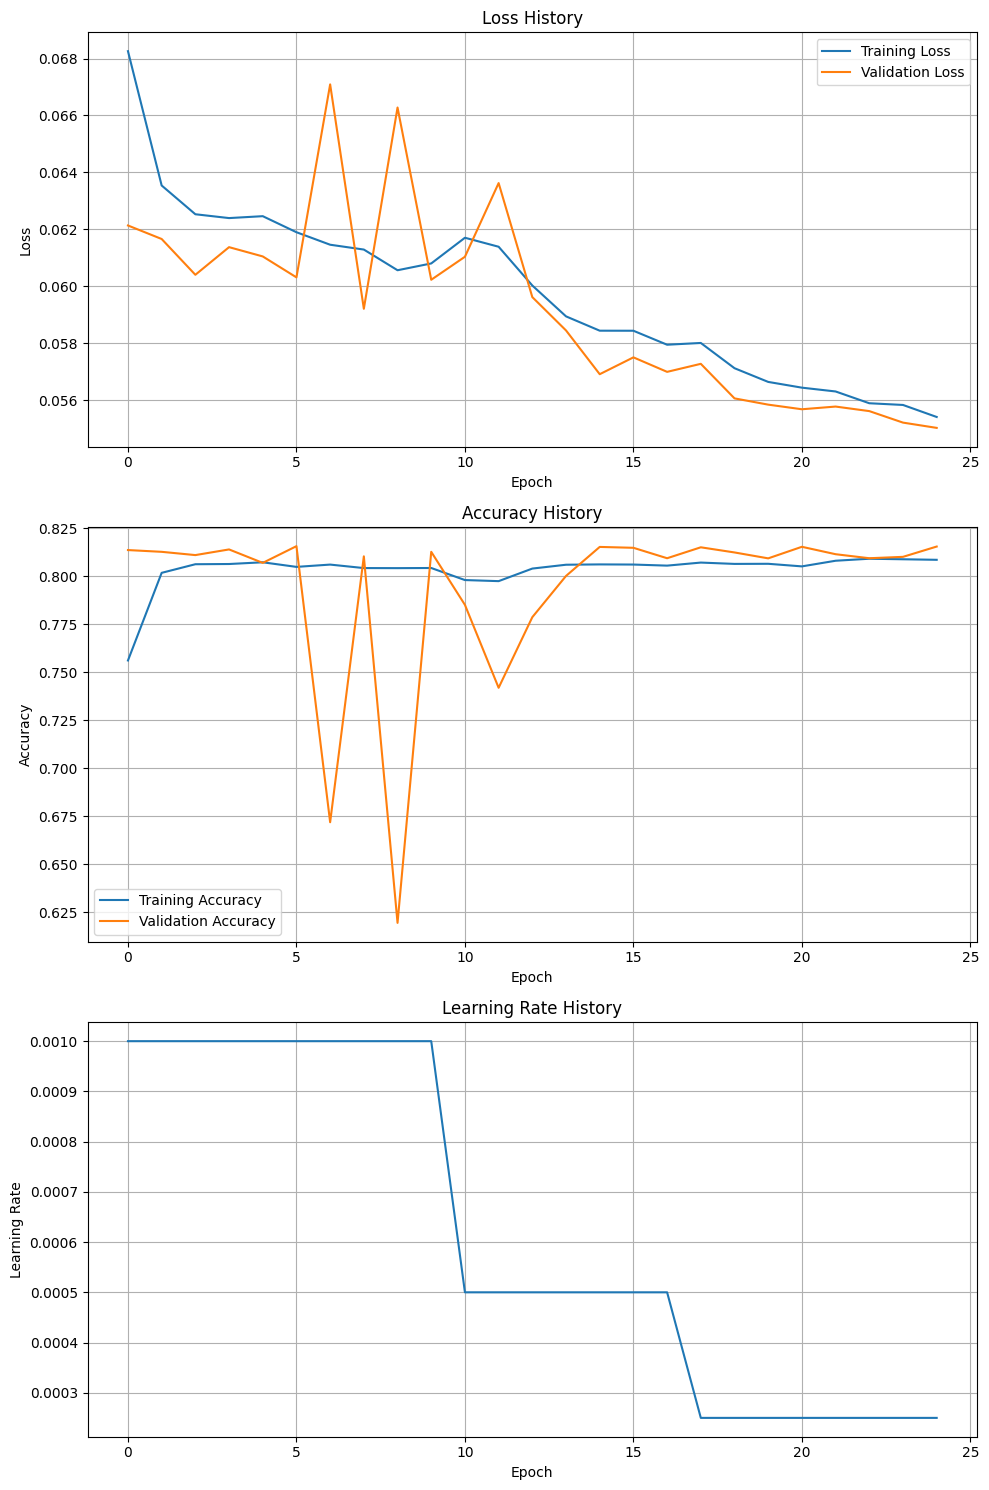

In [79]:
# Function to plot training history
def plot_training_history(history):
    """
    Plot training metrics history
    """
    import matplotlib.pyplot as plt
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
    
    # Plot losses
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss History')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Accuracy History')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    # Plot learning rate
    ax3.plot(history['learning_rates'])
    ax3.set_title('Learning Rate History')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

In [80]:
def evaluate_model(model: nn.Module, 
                  test_loader: torch.utils.data.DataLoader, 
                  device: torch.device) -> Tuple[float, float, float, float]:
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            pred = (out.squeeze() > 0.5).float()
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary'
    )
    accuracy = (all_preds == all_labels).mean()
    
    return accuracy, precision, recall, f1


# Evaluate model
accuracy, precision, recall, f1 = evaluate_model(model, test_loader, device)
print(f'Test Metrics:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Test Metrics:
Accuracy: 0.8188
Precision: 0.8453
Recall: 0.9204
F1 Score: 0.8812
